# Praktische Übung 4
## Generative Adversarial Networks

In dieser praktischen Übung sollen Sie ein conditional GAN für die Generierung von Blutzellbildern implementieren.

Zur Erinnerung:
Generative adversarial networks (GANs) wurden 2014 von [I.J. Goodfellow et al.](https://arxiv.org/pdf/1406.2661.pdf) vorgeschlagen. Ein GAN besteht aus zwei neuronalen Netzen, dem Generator und dem Diskriminator. Der Generator (der "Künstler") wird trainiert, realistisch aussehende Bilder zu generieren, während der Diskriminator (der "Kunstkritiker") lernt, echte und gefälschte Bilder zu unterscheiden.

Das Training eines GANs enstpricht einem Minimax-Spiel mit zwei Spielern. Der **Diskriminator** ist ein Klassifikationsnetzwerk mit zwei Ausgabeklassen (real/fake) und wird trainiert, indem der Klassifikationsfehler **minimiert** wird.
Der **Generator** erhält Zufallsvektoren als Eingabe und das Trainingsziel des Generators ist es, die Wahrscheinlichkeit, dass der Diskriminator einen Fehler macht, zu **maximieren**. Währen des Trainings wird der Generator immer besser darin, echt aussehende Bilder zu erzeugen und der Diskriminator kann immer besser echte und gefälschte Bilder voneinander unterscheiden. Der Prozess erreicht einen Gleichgewichtszustand, wenn der Diskriminator echte und gefälschte Bilder nicht mehr unterscheiden kann [[1]](https://www.tensorflow.org/tutorials/generative/dcgan).

Das GAN, das wir hier implementieren, dient der Generierung von Blutzellbildern. Die Trainingsdaten sind die [BloodMNIST](https://medmnist.com/)-Daten. Der Datensatz besteht aus 11959 Trainingsbildern, 1712 Validierungsbildern und 3421 Testbildern. Jedes Bild zeigt eine Zelle der folgenden Zelltypen:

*   Basophile
*   Eosinophile
*   Erythroblasten
*   Unreife Granulozyten
*   Lymphozyten
*   Monozyten
*   Neutrophile
*   Thrombozyten (Blutplättchen)

Das trainierte GAN soll in der Lage sein, gezielt Bilder eines bestimmten Zelltyps zu generieren. Wir werden also ein conditional GAN implementieren. Informationen dazu finden Sie [hier](https://arxiv.org/pdf/1411.1784.pdf) oder [hier](https://pub.towardsai.net/a-beginners-guide-to-building-a-conditional-gan-d261e4d94882).

In [1]:
# Paketinstallation
!pip install medmnist
import medmnist
from medmnist import INFO, Evaluator
from sklearn.neighbors import NearestNeighbors


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data

from torch.autograd import Variable

In [2]:
# Download des BloodMNIST-Datensatzes
data_flag = 'bloodmnist'

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

img_size = 32
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size)
])

train_dataset = DataClass(split='train',
                          transform=transform,
                          download=True,
                          size=batch_size,
                          mmap_mode='r')

# DataLoader aufsetzen
train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               drop_last=True)
img, label = train_dataset[1]
print('Image size: ', img.shape, 'Label shape: ', label.shape)

Image size:  torch.Size([3, 32, 32]) Label shape:  (1,)


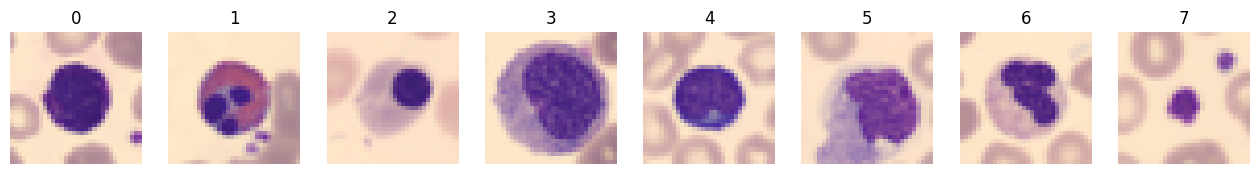

In [3]:
# Plot eines Bildes für jede Klasse
fig, ax = plt.subplots(1, 8, figsize=(16, 4))

for label in range(8):
  plotted = False
  idx = 0
  while not plotted:
    x, y = train_dataset[idx]
    if y.item() == label:
      ax[label].imshow(x.numpy().transpose(1, 2, 0))
      ax[label].title.set_text(y.item())
      ax[label].set_axis_off()
      plotted = True
    idx += 1

## Aufgabe 1
Sie sind dran! Implementieren Sie den Generator und den Diskriminator. Halten Sie sich dabei an die folgenden Architekturen:

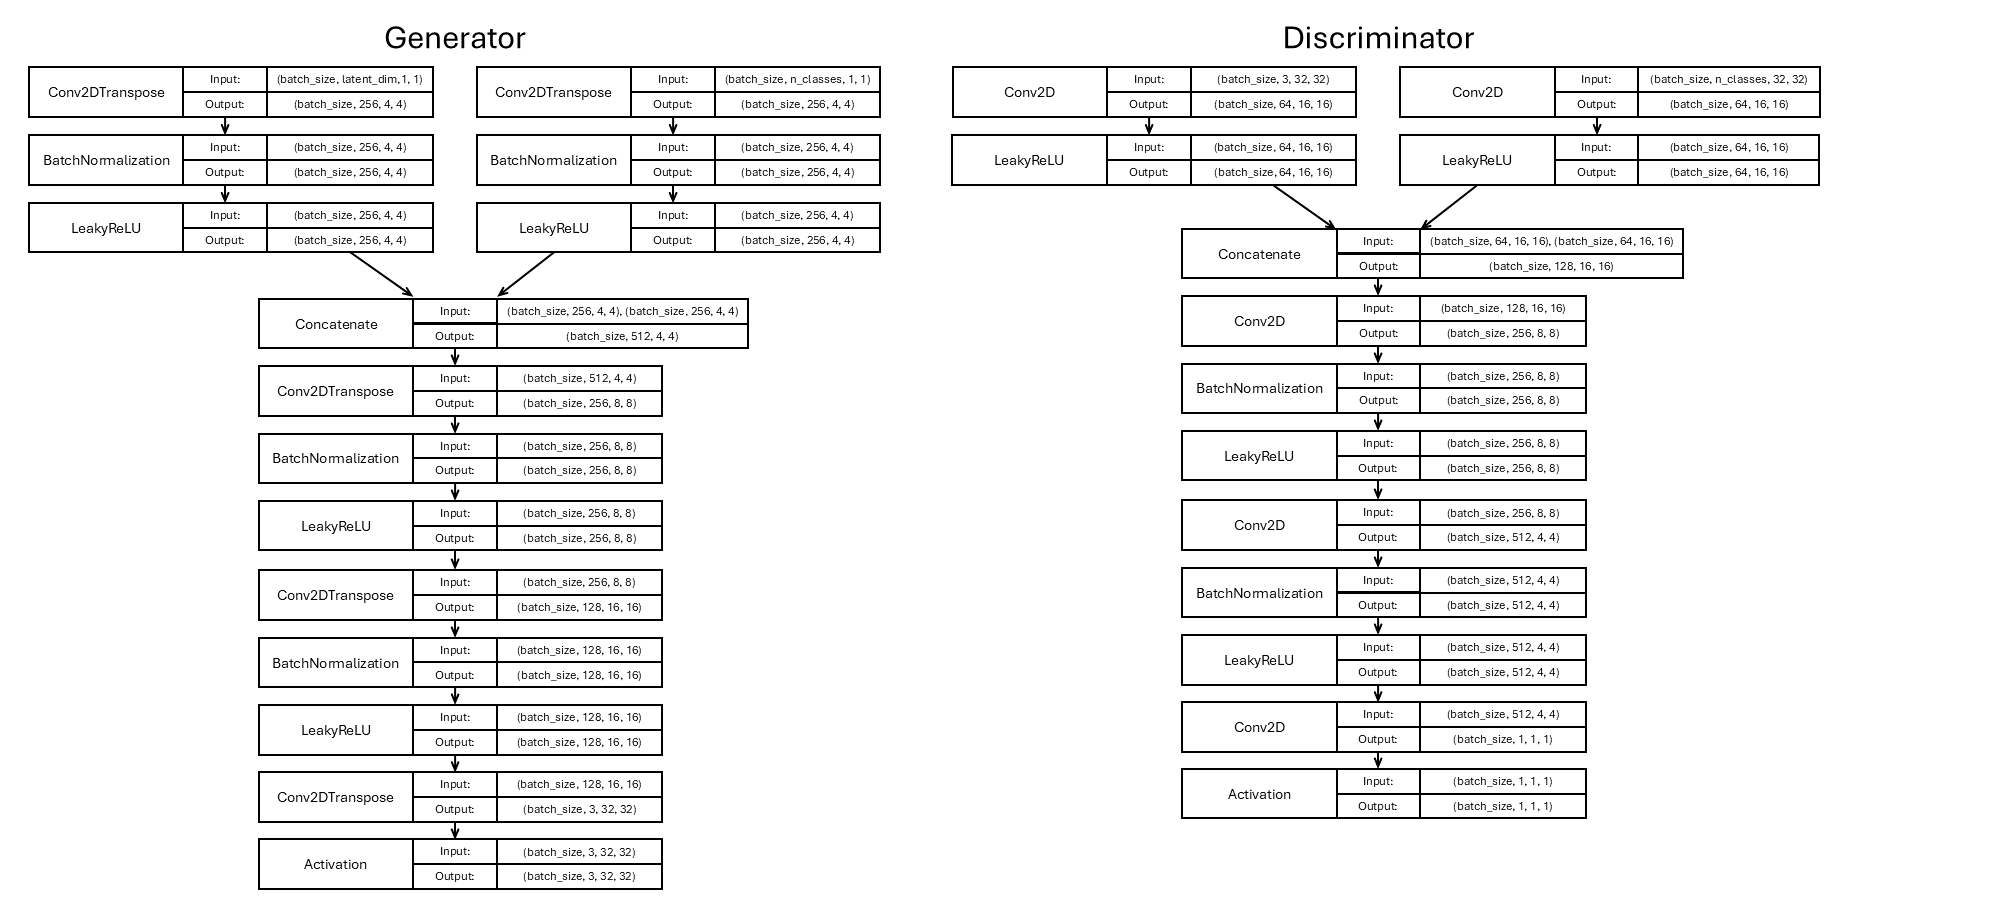

Hier wird LeakyReLU als Aktivierungsfunktion verwendet. Nutzen Sie als Aktivierungsfunktion in der letzen Schicht beider Netzwerke die Sigmoid-Funktion. Alle (transponierten) Faltungen sollen eine Filtergröße von 4x4 mit einem Stride von 2 und Padding von 1 verwenden, außer die Eingabeschichte des Generators, die einen Stride von 1 und kein Padding verwendet.

In [4]:
#import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, n_classes, n_channels, latent_dim, n_features=256):
        super(Generator, self).__init__()

        self.latent_path = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, n_features, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(n_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.label_path = nn.Sequential(
            nn.ConvTranspose2d(n_classes, n_features, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(n_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.main_path = nn.Sequential(
            nn.ConvTranspose2d(n_features * 2, n_features, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n_features),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(n_features, n_features // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n_features // 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(n_features // 2, n_channels, kernel_size=4, stride=2, padding=1),

            # Finale Aktivierungsfunktion
            nn.Sigmoid()
        )

    def forward(self, noise, label):
        latent_output = self.latent_path(noise)
        label_output = self.label_path(label)

        x = torch.cat((latent_output, label_output), dim=1)

        x = self.main_path(x)

        return x

class Discriminator(nn.Module):
    def __init__(self, n_classes, n_channels, n_features=64):
        super(Discriminator, self).__init__()

        self.image_path = nn.Sequential(
            nn.Conv2d(n_channels, n_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.label_path = nn.Sequential(
            nn.Conv2d(n_classes, n_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.main_path = nn.Sequential(
            nn.Conv2d(n_features * 2, n_features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_features * 4, n_features * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(n_features * 8, 1, kernel_size=4, stride=1, padding=0),

            nn.Sigmoid()
        )

    def forward(self, image, label):
        image_output = self.image_path(image)
        label_output = self.label_path(label)

        x = torch.cat((image_output, label_output), dim=1)

        x = self.main_path(x)

        return x.view(x.size(0), -1)

## Aufgabe 2
Implementieren Sie die Trainingsschleife, indem Sie die Lücken im Code ausfüllen. Nutzen Sie die binäre Kreuzentropie als Loss-Funktion.

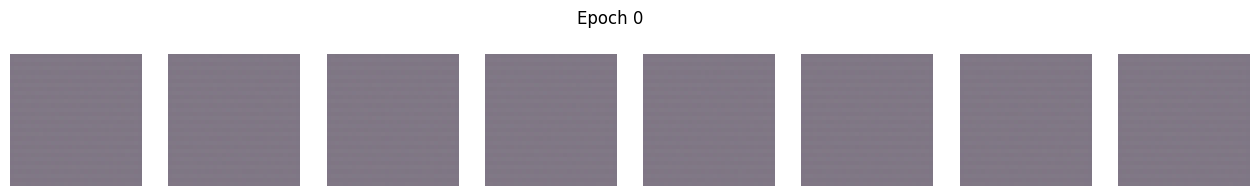

[Epoch 1/50] [D loss: 0.657058] [G loss: 1.595154]
[Epoch 2/50] [D loss: 0.638221] [G loss: 1.066841]
[Epoch 3/50] [D loss: 0.643838] [G loss: 1.050649]
[Epoch 4/50] [D loss: 0.637422] [G loss: 1.086284]
[Epoch 5/50] [D loss: 0.598901] [G loss: 1.378374]


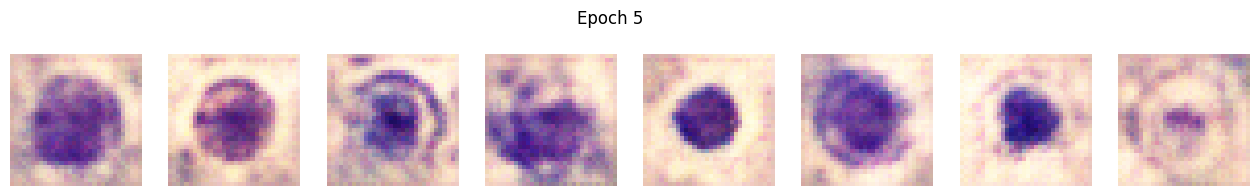

[Epoch 6/50] [D loss: 0.598852] [G loss: 1.380976]
[Epoch 7/50] [D loss: 0.555546] [G loss: 1.550805]
[Epoch 8/50] [D loss: 0.524204] [G loss: 1.656138]
[Epoch 9/50] [D loss: 0.507230] [G loss: 1.764322]
[Epoch 10/50] [D loss: 0.479783] [G loss: 1.848993]


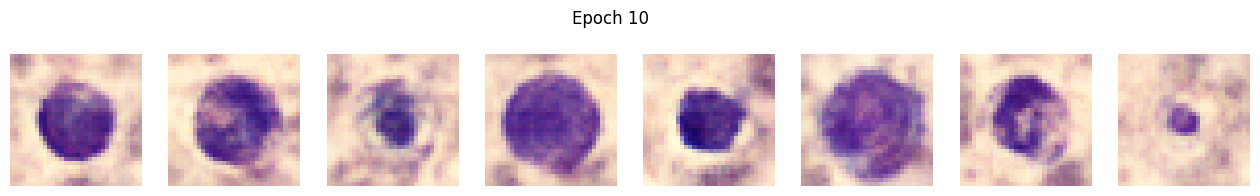

[Epoch 11/50] [D loss: 0.446342] [G loss: 1.926952]
[Epoch 12/50] [D loss: 0.433402] [G loss: 2.038435]
[Epoch 13/50] [D loss: 0.399982] [G loss: 2.122616]
[Epoch 14/50] [D loss: 0.382930] [G loss: 2.177826]
[Epoch 15/50] [D loss: 0.342940] [G loss: 2.471716]


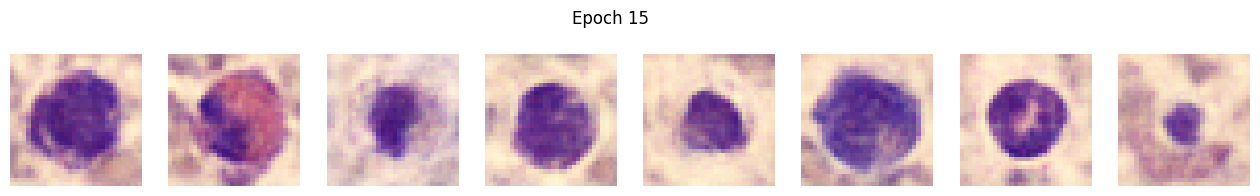

[Epoch 16/50] [D loss: 0.329558] [G loss: 2.439405]
[Epoch 17/50] [D loss: 0.317389] [G loss: 2.482960]
[Epoch 18/50] [D loss: 0.304149] [G loss: 2.553118]
[Epoch 19/50] [D loss: 0.255640] [G loss: 2.920833]
[Epoch 20/50] [D loss: 0.244819] [G loss: 2.792225]


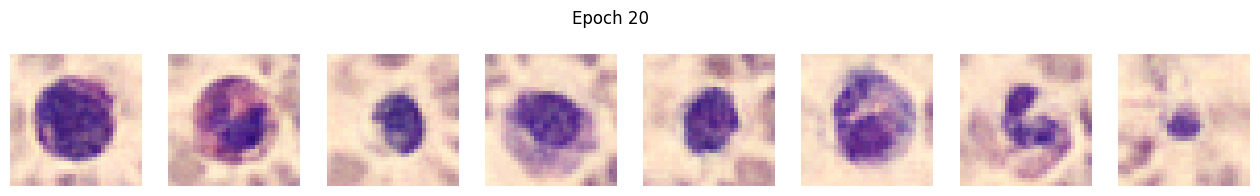

[Epoch 21/50] [D loss: 0.250290] [G loss: 2.607229]
[Epoch 22/50] [D loss: 0.272404] [G loss: 2.806355]
[Epoch 23/50] [D loss: 0.238058] [G loss: 2.769253]
[Epoch 24/50] [D loss: 0.200849] [G loss: 3.216689]
[Epoch 25/50] [D loss: 0.215142] [G loss: 3.024245]


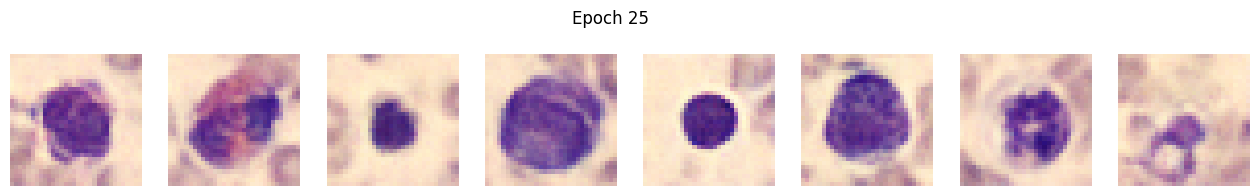

[Epoch 26/50] [D loss: 0.229938] [G loss: 2.869848]
[Epoch 27/50] [D loss: 0.209067] [G loss: 3.098140]
[Epoch 28/50] [D loss: 0.177162] [G loss: 3.122929]
[Epoch 29/50] [D loss: 0.129544] [G loss: 3.560776]
[Epoch 30/50] [D loss: 0.243391] [G loss: 3.035419]


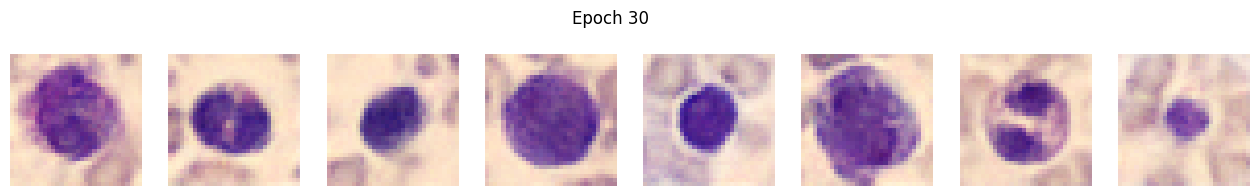

[Epoch 31/50] [D loss: 0.234824] [G loss: 2.932366]
[Epoch 32/50] [D loss: 0.182966] [G loss: 3.294135]
[Epoch 33/50] [D loss: 0.170810] [G loss: 3.343311]
[Epoch 34/50] [D loss: 0.186381] [G loss: 3.440378]
[Epoch 35/50] [D loss: 0.117104] [G loss: 3.994220]


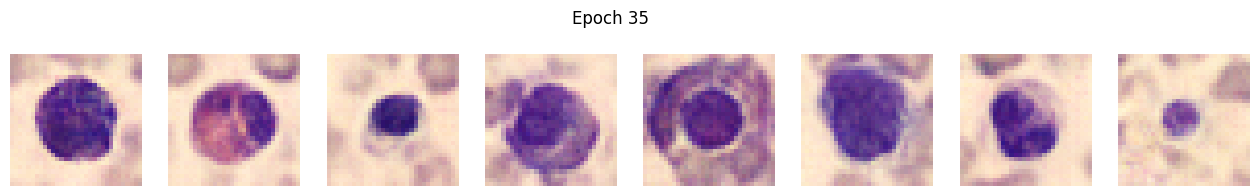

[Epoch 36/50] [D loss: 0.191638] [G loss: 3.125651]
[Epoch 37/50] [D loss: 0.242120] [G loss: 3.162488]
[Epoch 38/50] [D loss: 0.154918] [G loss: 3.415530]
[Epoch 39/50] [D loss: 0.142948] [G loss: 3.676940]
[Epoch 40/50] [D loss: 0.121319] [G loss: 3.861916]


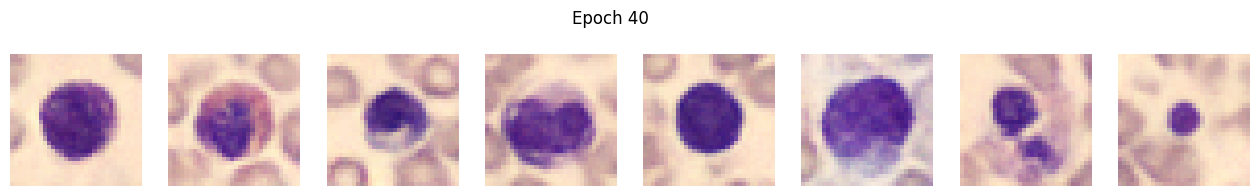

[Epoch 41/50] [D loss: 0.280718] [G loss: 3.280003]
[Epoch 42/50] [D loss: 0.102941] [G loss: 3.449066]
[Epoch 43/50] [D loss: 0.194839] [G loss: 3.626522]
[Epoch 44/50] [D loss: 0.187400] [G loss: 3.398089]
[Epoch 45/50] [D loss: 0.143774] [G loss: 3.843997]


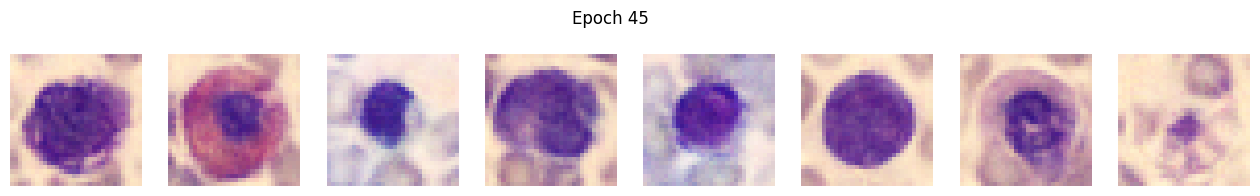

[Epoch 46/50] [D loss: 0.117953] [G loss: 3.689979]
[Epoch 47/50] [D loss: 0.180511] [G loss: 3.611866]
[Epoch 48/50] [D loss: 0.136889] [G loss: 3.812017]
[Epoch 49/50] [D loss: 0.184239] [G loss: 3.481634]
[Epoch 50/50] [D loss: 0.194181] [G loss: 3.539969]


In [5]:
# Hyperparameter
lr = 0.0002
n_epochs = 50
n_classes = 8
latent_dim = 100 # Eine gängige und gute Wahl für die latente Dimension
n_channels = 3
sample_interval = 5

# Binary Cross-Entropy
loss_fn = nn.BCELoss()

# Initialisiere Generator und Diskriminator
generator = Generator(n_classes=n_classes, n_channels=n_channels, latent_dim=latent_dim)
discriminator = Discriminator(n_classes=n_classes, n_channels=n_channels)

# Modelle und Loss-Funktion auf die GPU verschieben
generator.cuda()
discriminator.cuda()
loss_fn.cuda()

# Optimierer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# ----------
#  Training
# ----------
for epoch in range(n_epochs):
  disc_losses = []
  gen_losses = []

  epoch_loss_D = 0
  epoch_loss_G = 0

  # Plotte generierte Bilder alle sample_interval Epochen
  if epoch % sample_interval == 0:
    generator.eval() # In den Evaluationsmodus wechseln für die Inferenz
    with torch.no_grad():
      fig, ax = plt.subplots(1, 8, figsize=(16,2))
      for label in range(8):
        noise = torch.randn(1, latent_dim, 1, 1).cuda()
        label_input = F.one_hot(torch.tensor([label]), n_classes).float().view(-1, n_classes, 1, 1).cuda()
        gen_image = generator(noise, label_input)
        ax[label].imshow(gen_image[0, ...].cpu().detach().numpy().transpose(1, 2, 0))
        ax[label].set_axis_off()
      fig.suptitle('Epoch ' + str(epoch), y=1.05)
      plt.show()
    generator.train() # Zurück in den Trainingsmodus

  # Haupttrainingsschleife
  for i, (imgs, labels) in enumerate(train_loader):

    # Labels für den Generator vorbereiten: [batch_size, n_classes, 1, 1]
    g_labels = F.one_hot(labels, num_classes=n_classes).float().view(-1, n_classes, 1, 1).cuda()

    # Labels für den Diskriminator vorbereiten: [batch_size, n_classes, 32, 32]
    d_labels = g_labels.expand(-1, -1, imgs.size(2), imgs.size(3))
    imgs = imgs.cuda()

    # Ground-Truth Labels: 1.0 für "echt", 0.0 für "gefälscht".
    # Die Form muss mit dem Output des Diskriminators übereinstimmen: (batch_size, 1)
    y_real = torch.full((batch_size, 1), 1.0, dtype=torch.float, device='cuda')
    y_fake = torch.full((batch_size, 1), 0.0, dtype=torch.float, device='cuda')

    # -----------------------------
    #  Training des Diskriminators
    # -----------------------------
    discriminator.zero_grad()

    # Berechne Loss auf echten Bildern
    D_out_real = discriminator(imgs, d_labels)
    D_loss_real = loss_fn(D_out_real, y_real)

    # Berechne Loss auf gefälschten Bildern
    noise = torch.randn(batch_size, latent_dim, 1, 1, device='cuda')
    # .detach() verhindert, dass der Generator während des Diskriminator-Trainings aktualisiert wird.
    gen_image = generator(noise, g_labels).detach()

    D_out_fake = discriminator(gen_image, d_labels)
    D_loss_fake = loss_fn(D_out_fake, y_fake)

    # Addiere beide Losses und führe Backpropagation durch
    D_loss = (D_loss_real + D_loss_fake) / 2
    D_loss.backward()
    optimizer_D.step()

    disc_losses.append(D_loss.item())
    epoch_loss_D += D_loss.item()

    # -------------------------
    #  Training des Generators
    # -------------------------
    generator.zero_grad()

    # Ziel: Den Diskriminator täuschen.
    # Erzeuge einen neuen Batch gefälschter Bilder.
    noise = torch.randn(batch_size, latent_dim, 1, 1, device='cuda')
    gen_image = generator(noise, g_labels)

    # Schicke die gefälschten Bilder durch den Diskriminator.
    D_out_gen = discriminator(gen_image, d_labels)
    # Berechne den Loss für den Generator. Der Generator gewinnt, wenn der Diskriminator
    gen_loss = loss_fn(D_out_gen, y_real)

    # Backpropagation
    gen_loss.backward()
    optimizer_G.step()

    gen_losses.append(gen_loss.item())
    epoch_loss_G += gen_loss.item()

  print(
      "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
      % (epoch+1, n_epochs, epoch_loss_D/len(disc_losses), epoch_loss_G/len(gen_losses))
  )

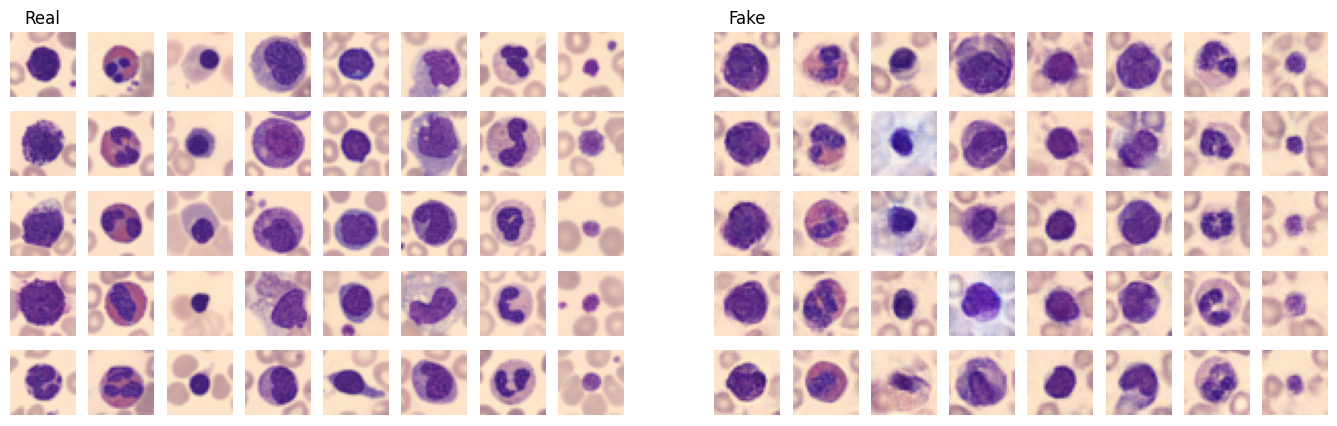

In [6]:
# Setze den Generator in den Evaluationsmodus
generator.eval()

fig, ax = plt.subplots(5, 17, figsize=(17,5))

# Echte Bilder plotten
for label in range(8):
  plotted = 0
  idx = 0
  while plotted < 5:
    x, y = train_dataset[idx]
    if y.item() == label:
      ax[plotted, label].imshow(x.numpy().transpose(1, 2, 0))
      plotted += 1
    idx += 1

# Gefälschte Bilder generieren und plotten
for row in range(5):
  for label in range(8):
    with torch.no_grad():
      noise = torch.randn(1, latent_dim, 1, 1).cuda()
      label_input = F.one_hot(torch.tensor([label]), n_classes).float().view(-1, n_classes, 1, 1).cuda()
      gen_image = generator(noise, label_input)

    ax[row, label + 9].imshow(gen_image[0].cpu().detach().numpy().transpose(1, 2, 0))

# Achsen und Titel formatieren
[axi.set_axis_off() for axi in ax.ravel()]
ax[0, 0].title.set_text('Real')
ax[0, 9].title.set_text('Fake')
plt.show()


## Aufgabe 3
**a)** Die Bewertung generativer Modelle ist schwierig und kann nur durch Qualitätsbewertung der synthetisierten Bilder geschehen. Ein erster Schritt dabei ist die manuelle Bewertung der generierten Bilder: [Blog-Post](https://towardsdatascience.com/on-the-evaluation-of-generative-adversarial-networks-b056ddcdfd3a). Wie bewerten Sie die Qualität der von Ihnen erzeugten Bilder?

**Analyse:**
Bei der Gegenüberstellung der echten und der generierten Mikroskopaufnahmen fällt sofort auf, dass der Generator die charakteristische lila-rosa Farbgebung und den zentralen, dunklen Zellkern mit umgebendem Zytoplasma sehr sauber reproduziert. Die einzelnen Zelltypen sind deutlich unterscheidbar und es zeigt sich kein kompletter Mode Collapse. Gleichzeitig sind die Zellränder in den Fake-Bildern etwas weichgezeichnet, feine Membran- und Kerntexturen gehen verloren, und der Hintergrund bleibt mitunter zu homogen, weil typische Artefakte echter Präparate fehlen


Natürlich hat die manuelle Bewertung einige Nachteile:

*   Subjektiv und beeinflusst von den Biases der bewertenden Person
*   Erfordert Expertenwissen zur Bewertung, was realistisch ist und was nicht
*   Nur begrenzte Anzahl von Bildern kann manuell bewertet werden

Für eine quantitative Bewertung des GANs müssen drei Eigenschaften untersucht werden:

1.   Fidelity (Wiedergabetreue) = Qualität der generierten Bilder. Bewertet, wie realistisch die generierten Bildern sind. Intuition: Wie ähnlich sieht jedes gefälschte Bild seinem ähnlichsten echten Bild?
2.   Diversität = Vielfalt der generierten Bilder. Bewertet, inwiefern die generierten Bilder die gesamte Varianz der echten Datenverteilung abdecken.
3.    Authentizität/Generalisierbarkeit = Anteil an gefälschten Bildern, die einem echten Bilder ähnlich sehen als andere Trainingsbilder: Bewertet, wie gut das Modell darin ist, neue Samples zu generieren; versucht, Overfitting zu erkennen [Alaa et al.](https://arxiv.org/abs/2102.08921)

Schließlich sollten die synthetischen Daten für nachfolgende Aufagen genauso nützlich sein wie echte Daten.

4.    Prädiktive Performance: Training eines Klassifikators auf synthetischen Daten und Testen auf echten Daten. Bewertet, wie gut die synthetischen Daten die Verteilung der echten Daten approximieren.

**b)** Trainieren Sie ein Klassifikationsnetzwerk auf den gefälschten Daten. Das Netzwerk soll für jedes Eingabebild den korrekten Zelltyp bestimmen. Testen Sie Ihr Modell auf den echten BloodMNIST-Daten.

Sie können hierfür das gleiche Netzwerk verwenden wie in der letzten Übung. Passen Sie nur die Anzahl an Eingabe-Channels und die Anzahl an Ausgabe-Features entsprechend des Formates der Trainingsbilder und Blutzellklassen an.

In [23]:

class ConvBlock(nn.Module):
    """Conv → BN → ReLU → MaxPool (2×2)"""
    def __init__(self, in_c: int, out_c: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        return self.conv_block(x)


class Classification_CNN(nn.Module):
    """3 ConvBlocks  → GAP → FC (Dropout)"""
    def __init__(self, in_channels: int = 3, num_classes: int = 8):
        super().__init__()

        self.conv_layers = nn.Sequential(
            ConvBlock(in_channels, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128)
        )

        # macht das Netz größen-agnostisch
        self.gap = nn.AdaptiveAvgPool2d(1)      # (B,128,1,1) → 128

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.20),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=5**0.5)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.gap(x).flatten(1)
        x = self.fc_layers(x)
        return x


In [25]:
classification_mdl = Classification_CNN(in_channels=n_channels, num_classes=n_classes).cuda()
optimizer = torch.optim.Adam(classification_mdl.parameters())
criterion = nn.CrossEntropyLoss()

steps = 20
batch_size = 64
n_epochs = 50

train_loss = torch.zeros(n_epochs)
train_acc = torch.zeros(n_epochs)

classification_mdl.train()
generator.eval()

for epoch in range(n_epochs):

    for step in range(steps):
      labels = torch.randint(0, n_classes, (batch_size,)).cuda()
      g_labels = F.one_hot(labels, num_classes=n_classes).float().view(-1, n_classes, 1, 1).cuda()
      noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()

      with torch.no_grad():
        gen_image = generator(noise, g_labels)

      # Setze die Gradienten des Optimierers zurück
      optimizer.zero_grad()
      # Schicke das generierte Bild durch das Klassifikationsnetzwerk
      logits = classification_mdl(gen_image)
      loss = criterion(logits, labels)

      #Backpropagation
      loss.backward()
      #Aktualisiere die Gewichte des Modells basierend auf den Gradienten .zero_grad()
      optimizer.step()

      train_loss[epoch] += loss.detach().cpu()
      train_acc[epoch] += torch.sum(torch.argmax(logits, dim=1) == labels).cpu()

train_loss /= steps
train_acc /= (steps*batch_size)

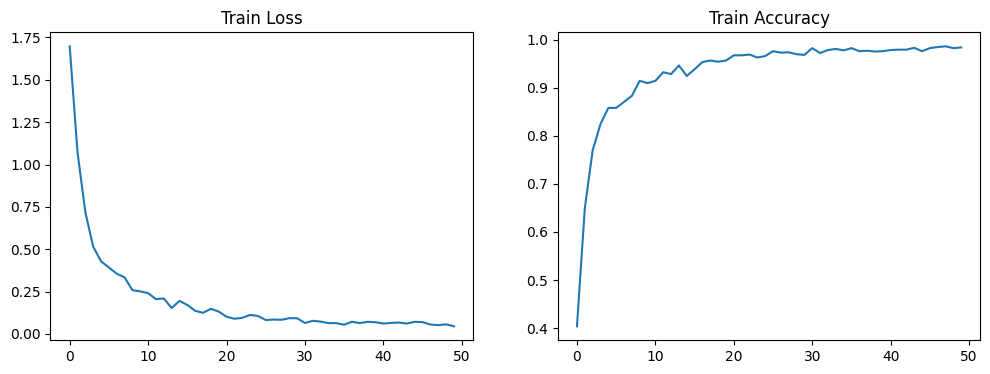

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss)
ax[0].title.set_text('Train Loss')
ax[1].plot(train_acc)
ax[1].title.set_text('Train Accuracy');

In [27]:
test_dataset = DataClass(split='test',
                         transform=transform,
                         download=True,
                         size=64,
                         mmap_mode='r')

# Set up testing data loader
test_loader = data.DataLoader(dataset=test_dataset, batch_size=1)

real_labels = []
pred_labels = []
pred_labels2 = []

classification_mdl.eval()
for i, (img, label) in enumerate(test_loader):

  real_labels.append(label.item())
  logits = classification_mdl(img.cuda())
  pred_labels.append(torch.argmax(logits).item())


In [28]:
# Accuracy
acc = (np.array(real_labels) == np.array(pred_labels)).sum() / len(test_dataset)
print('Accuracy on real test images: ', acc)

Accuracy on real test images:  0.8322128032738966


In [32]:
# α-Precision, β-Recall, Authenticity
device = next(classification_mdl.parameters()).device

# 1) Feature-Extractor: Conv-Blöcke, FC abkappen
feature_net = torch.nn.Sequential(
    classification_mdl.conv_layers
).to(device).eval()

def get_features(loader):
    feats = []
    with torch.no_grad():
        for xb, _ in loader:
            feats.append(feature_net(xb.to(device)).flatten(1).cpu())
    return torch.cat(feats).numpy()

real_loader = test_loader
fake_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        generator(
            torch.randn(5000, latent_dim, 1, 1, device=device),
            F.one_hot(torch.randint(0, n_classes, (5000,), device=device),
                      n_classes).float().view(-1, n_classes, 1, 1)
        ).detach().cpu(),
        torch.zeros(5000)
    ),
    batch_size=128
)

F_real = get_features(real_loader)
F_fake = get_features(fake_loader)

# 2) Distanz-Utilities
def kth_nn_dist(X, k=3):
    d, _ = NearestNeighbors(n_neighbors=k+1).fit(X).kneighbors(X)
    return d[:, -1]

def cross_nn_dist(A, B, k=3):
    d, _ = NearestNeighbors(n_neighbors=k).fit(B).kneighbors(A)
    return d[:, -1]

k = 3
d_rr = kth_nn_dist(F_real, k)
d_gg = kth_nn_dist(F_fake, k)
d_rg = cross_nn_dist(F_fake, F_real, k)   # Fake → Real
d_gr = cross_nn_dist(F_real, F_fake, k)   # Real → Fake

# 3) α-Precision- & β-Recall-Kurven
grid = np.linspace(0, 1, 21)
P_alpha = [(d_rg <= np.quantile(d_rr, a)).mean() for a in grid]
R_beta  = [(d_gr <= np.quantile(d_gg, b)).mean() for b in grid]
IP = np.trapezoid(P_alpha, grid)          # integrierte α-Precision
IR = np.trapezoid(R_beta,  grid)          # integrierte β-Recall

# 4) Authenticity
r2r = kth_nn_dist(F_real, k=2)
nearest_real = NearestNeighbors(n_neighbors=1).fit(F_real).kneighbors(F_fake, return_distance=False).ravel()
A = (d_rg > r2r[nearest_real]).mean()

print(f"IP (α-Precision) = {IP:.3f}")
print(f"IR (β-Recall)    = {IR:.3f}")
print(f"A  (Authenticity) = {A:.3f}")


IP (α-Precision) = 0.496
IR (β-Recall)    = 0.312
A  (Authenticity) = 0.926


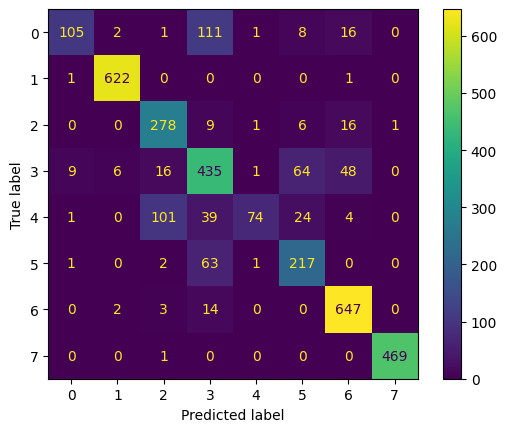

In [30]:
from sklearn import metrics

disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(real_labels, pred_labels))
disp.plot()
plt.show();

Wie bewerten Sie die Perfomance Ihres GANs?

Unser GAN erreicht eine Accuracy von 83,2 %. Die drei Metriken von  Alaa et al. geben jedoch ein nuancierteres Bild:
* Fidelity: Die integrierte α-Precision liegt bei IP = 0,496. Fast die Hälfte aller Fakes befindet sich also in den dichten Bereichen der Realverteilung genug, damit der CNN robuste Zellmerkmale erlernen kann, aber noch Luft nach oben.
* Diversity: Mit IR = 0,311 decken die Fakes nur rund ein Drittel der realen Variabilität ab. Seltene Zellklassen tauchen weiterhin zu selten auf; das erklärt, warum einige Confusion-Matrix-Spalten deutlich schwächer bleiben.
* Authentizität: Der Authenticity-Score A = 0,922 zeigt, dass nur knapp 8 % der Fakes verdächtig nah an ein Trainingsbild heranrücken, Overfitting ist also kaum ein Thema.

Zusammenfassend bestätigt die hohe Gesamt-Accuracy, dass die synthetischen Bilder nützlich sind; der Klassifikator generalisiert auf echte Daten. Gleichzeitig enthüllen die Metriken ein differenzierteres Bild: realistisch, aber noch nicht vielfältig genug.